In [1]:
# pip install ultralytics

In [4]:
# %%
import os, torch
print("cwd:", os.getcwd())
print("torch:", torch.__version__)
print("MPS:", torch.backends.mps.is_available())

device = "mps" if torch.backends.mps.is_available() else "cpu"
print("Using:", device)

cwd: /Users/omadj/Desktop/This PC/Samsung128/HOMEWORK/FALL 2025/II. MACHINE LEARNING/GROUP PROJECT/src
torch: 2.9.1
MPS: True
Using: mps


In [5]:
# %%
yaml_path = "../dataset/dataset.yaml"

yaml_text = """
path: ../dataset

train: train/images
val: valid/images
test: test/images

names:
  0: tumor
"""

with open(yaml_path, "w") as f:
    f.write(yaml_text.strip())

print(open(yaml_path).read())

path: ../dataset

train: train/images
val: valid/images
test: test/images

names:
  0: tumor


Visual sanity test

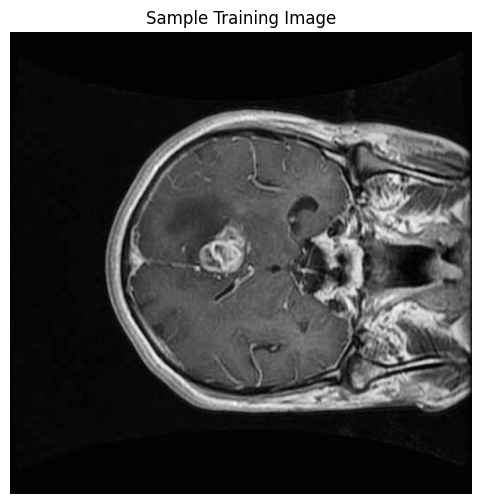

In [6]:
# %%
import json, cv2, random
import matplotlib.pyplot as plt

ann_file = "../dataset/train/_annotations.coco.json"
with open(ann_file, "r") as f:
    coco = json.load(f)

sample = random.choice(coco["images"])
filename = sample["file_name"]
img_path = f"../dataset/train/images/{filename}"

img = cv2.imread(img_path)
assert img is not None, img_path
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(6,6))
plt.imshow(img)
plt.title("Sample Training Image")
plt.axis("off")
plt.show()

Convert COCO → YOLO

In [9]:
# %%
import os, json
import numpy as np

def coco_seg_to_yolo_seg(json_path, img_dir, label_dir, class_id=0):
    """
    Convert COCO polygon segmentations → YOLOv8 segmentation labels.
    Each line:
    class x1 y1 x2 y2 ... xn yn
    (all coords normalized between 0 and 1)
    """
    os.makedirs(label_dir, exist_ok=True)
    coco = json.load(open(json_path, "r"))

    # Map image_id → (width, height, filename)
    id2info = {
        img["id"]: (img["width"], img["height"], img["file_name"])
        for img in coco["images"]
    }

    # Accumulate polygons per image
    anns_by_img = {}
    for ann in coco["annotations"]:
        anns_by_img.setdefault(ann["image_id"], []).append(ann)

    count = 0

    for img_id, anns in anns_by_img.items():
        w, h, fname = id2info[img_id]
        label_name = fname.rsplit(".", 1)[0] + ".txt"
        out_path = os.path.join(label_dir, label_name)

        with open(out_path, "w") as f:
            for ann in anns:
                # segmentation is a list of polygon lists → we use first poly
                seg = ann["segmentation"][0]

                # Convert to float BEFORE normalization
                pts = np.array(seg, dtype=np.float32).reshape(-1, 2)
                pts[:, 0] /= float(w)
                pts[:, 1] /= float(h)

                f.write(str(class_id))
                for x, y in pts:
                    f.write(f" {x:.6f} {y:.6f}")
                f.write("\n")

        count += 1

    print(f"Converted {count} images → {label_dir}")

# Run conversion
root = "../dataset"

coco_seg_to_yolo_seg(
    f"{root}/train/_annotations.coco.json",
    f"{root}/train/images",
    f"{root}/train/labels"
)

coco_seg_to_yolo_seg(
    f"{root}/valid/_annotations.coco.json",
    f"{root}/valid/images",
    f"{root}/valid/labels"
)

os.makedirs(f"{root}/test/labels", exist_ok=True)
print("Prepared test labels.")

Converted 1501 images → ../dataset/train/labels
Converted 429 images → ../dataset/valid/labels
Prepared test labels.


Clean corrupted labels

In [10]:
train_images = "../dataset/train/images"
train_labels = "../dataset/train/labels"

deleted = 0

for txt in os.listdir(train_labels):
    if not txt.endswith(".txt"):
        continue
    base = txt[:-4]

    candidates = [base + ext for ext in [".jpg",".jpeg",".png"]]

    exists = any(os.path.exists(os.path.join(train_images, c)) for c in candidates)
    if not exists:
        os.remove(os.path.join(train_labels, txt))
        deleted += 1

print("Deleted corrupted labels:", deleted)

Deleted corrupted labels: 0


Delete .cache before training

In [11]:
import glob

for cache in glob.glob("../dataset/**/*.cache", recursive=True):
    print("Deleting:", cache)
    os.remove(cache)

print("Cache cleared.")

Deleting: ../dataset/valid/labels.cache
Deleting: ../dataset/train/labels.cache
Cache cleared.


Train YOLOv8s (correct dirs)

In [ ]:
# %%
from ultralytics import YOLO

yaml_path = "../dataset/dataset.yaml"
model = YOLO("yolov8s-seg.pt")   # segmentation model

results = model.train(
    data=yaml_path,
    epochs=25,
    imgsz=640,
    batch=8,
    patience=5,
    device=device,
    workers=4,
    project="../experiments",
    name="yolo_seg_run1",
    save=True,
    save_period=1,
)

print("Training done → ../experiments/yolo_seg_run1")

Ultralytics 8.3.233 🚀 Python-3.13.2 torch-2.9.1 MPS (Apple M4 Max)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=../dataset/dataset.yaml, degrees=0.0, deterministic=True, device=mps, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=25, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8s-seg.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolo_seg_run12, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=5, perspective=0.0, plots=True, pose=12.0, pretrai

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/ultralytics/data/augment.py:1181: RuntimeWarning: divide by zero encountered in matmul
  xy = xy @ M.T  # transform
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/ultralytics/data/augment.py:1181: RuntimeWarning: overflow encountered in matmul
  xy = xy @ M.T  # transform
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/ultralytics/data/augment.py:1181: RuntimeWarning: invalid value encountered in matmul
  xy = xy @ M.T  # transform


       1/25      8.64G       1.92     0.6134       2.91      1.908          8        640: 100% ━━━━━━━━━━━━ 188/188 1.6it/s 1:570.8sss
WARNING ⚠️ NMS time limit 2.800s exceeded
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 67% ━━━━━━━━──── 18/27 3.7s/it 1:10<33.5ssWARNING ⚠️ NMS time limit 2.800s exceeded
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 27/27 3.6s/it 1:372.3ss
                   all        429        429      0.278      0.291      0.241      0.113      0.274      0.287      0.236      0.103

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/ultralytics/data/augment.py:1181: RuntimeWarning: divide by zero encountered in matmul
  xy = xy @ M.T  # transform
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/ultralytics/data/augment.py:1181: RuntimeWarning: overflow encountered in matmul
  xy = xy @ M.T  # transform
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/ultralytics/data/augment.py:1181: RuntimeWarning: invalid value encountered in matmul
  xy = xy @ M.T  # transform


       2/25      8.61G      1.889    0.02357      2.092      1.914          9        640: 100% ━━━━━━━━━━━━ 188/188 1.9it/s 1:390.5sss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 27/27 2.6s/it 1:102.1sss
                   all        429        429      0.589      0.462      0.469      0.261      0.559      0.466      0.471      0.254

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/ultralytics/data/augment.py:1181: RuntimeWarning: divide by zero encountered in matmul
  xy = xy @ M.T  # transform
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/ultralytics/data/augment.py:1181: RuntimeWarning: overflow encountered in matmul
  xy = xy @ M.T  # transform
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/ultralytics/data/augment.py:1181: RuntimeWarning: invalid value encountered in matmul
  xy = xy @ M.T  # transform


       3/25      8.71G      1.844   0.003311      2.023      1.866         10        640: 100% ━━━━━━━━━━━━ 188/188 1.7it/s 1:510.6ss
WARNING ⚠️ NMS time limit 2.800s exceeded
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 4% ──────────── 1/27 11.3s/it 3.4s<4:53WARNING ⚠️ NMS time limit 2.800s exceeded
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 7% ╸─────────── 2/27 6.6s/it 6.7s<2:44WARNING ⚠️ NMS time limit 2.800s exceeded
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 11% ━─────────── 3/27 5.2s/it 10.2s<2:04WARNING ⚠️ NMS time limit 2.800s exceeded
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 15% ━╸────────── 4/27 4.5s/it 13.6s<1:43WARNI

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/ultralytics/data/augment.py:1181: RuntimeWarning: divide by zero encountered in matmul
  xy = xy @ M.T  # transform
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/ultralytics/data/augment.py:1181: RuntimeWarning: overflow encountered in matmul
  xy = xy @ M.T  # transform
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/ultralytics/data/augment.py:1181: RuntimeWarning: invalid value encountered in matmul
  xy = xy @ M.T  # transform


       4/25      8.63G       1.86   0.001244      1.957      1.875         15        640: 100% ━━━━━━━━━━━━ 188/188 1.7it/s 1:520.6ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 27/27 2.1s/it 56.6s1.3ss
                   all        429        429      0.613      0.551       0.57      0.289      0.604      0.544      0.553       0.27

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/ultralytics/data/augment.py:1181: RuntimeWarning: divide by zero encountered in matmul
  xy = xy @ M.T  # transform
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/ultralytics/data/augment.py:1181: RuntimeWarning: overflow encountered in matmul
  xy = xy @ M.T  # transform
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/ultralytics/data/augment.py:1181: RuntimeWarning: invalid value encountered in matmul
  xy = xy @ M.T  # transform


       5/25      8.67G      1.765   0.001267      1.807      1.814         10        640: 100% ━━━━━━━━━━━━ 188/188 1.4it/s 2:120.6ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 27/27 1.3s/it 35.1s1.0ss
                   all        429        429      0.737      0.569      0.664      0.369      0.745      0.572      0.668      0.373

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/ultralytics/data/augment.py:1181: RuntimeWarning: divide by zero encountered in matmul
  xy = xy @ M.T  # transform
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/ultralytics/data/augment.py:1181: RuntimeWarning: overflow encountered in matmul
  xy = xy @ M.T  # transform
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/ultralytics/data/augment.py:1181: RuntimeWarning: invalid value encountered in matmul
  xy = xy @ M.T  # transform


       6/25      8.69G      1.739   0.006432      1.722      1.768          9        640: 100% ━━━━━━━━━━━━ 188/188 1.2it/s 2:310.8ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 27/27 1.1s/it 30.5s1.1ss
                   all        429        429      0.768      0.566      0.679      0.376      0.758      0.559      0.672      0.379

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/ultralytics/data/augment.py:1181: RuntimeWarning: divide by zero encountered in matmul
  xy = xy @ M.T  # transform
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/ultralytics/data/augment.py:1181: RuntimeWarning: overflow encountered in matmul
  xy = xy @ M.T  # transform
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/ultralytics/data/augment.py:1181: RuntimeWarning: invalid value encountered in matmul
  xy = xy @ M.T  # transform


       7/25      8.63G      1.719  0.0002551      1.695       1.77         13        640: 57% ━━━━━━╸───── 108/188 1.1it/s 1:27<1:13s

Evaluate model (mIoU + mAP)


0: 640x640 1 tumor, 59.0ms
Speed: 0.8ms preprocess, 59.0ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 640)


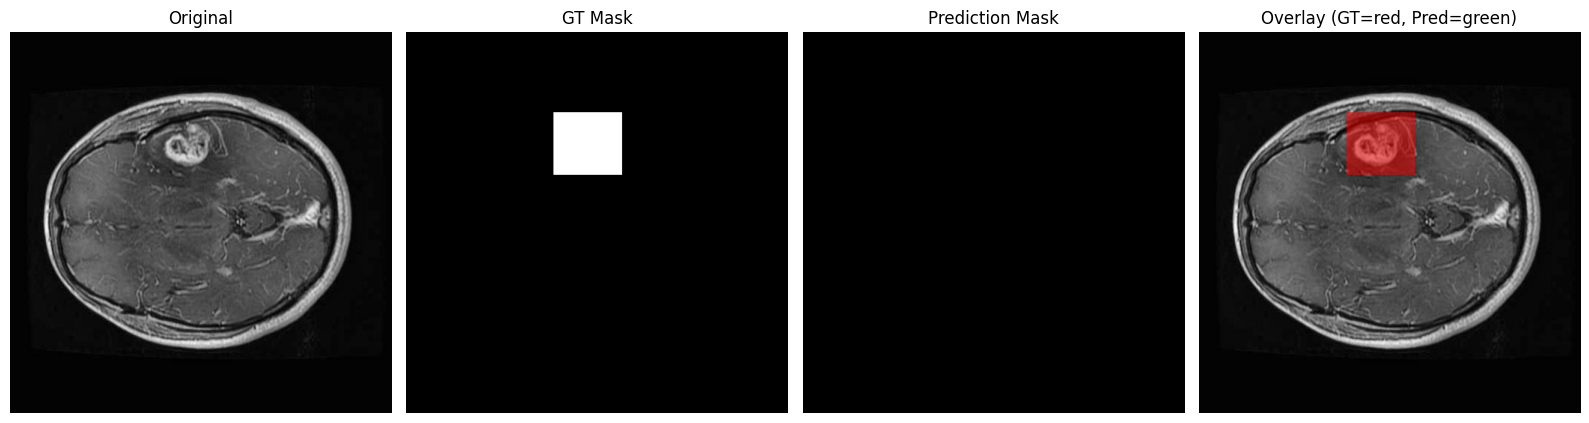


0: 640x640 1 tumor, 60.0ms
Speed: 0.8ms preprocess, 60.0ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 640)


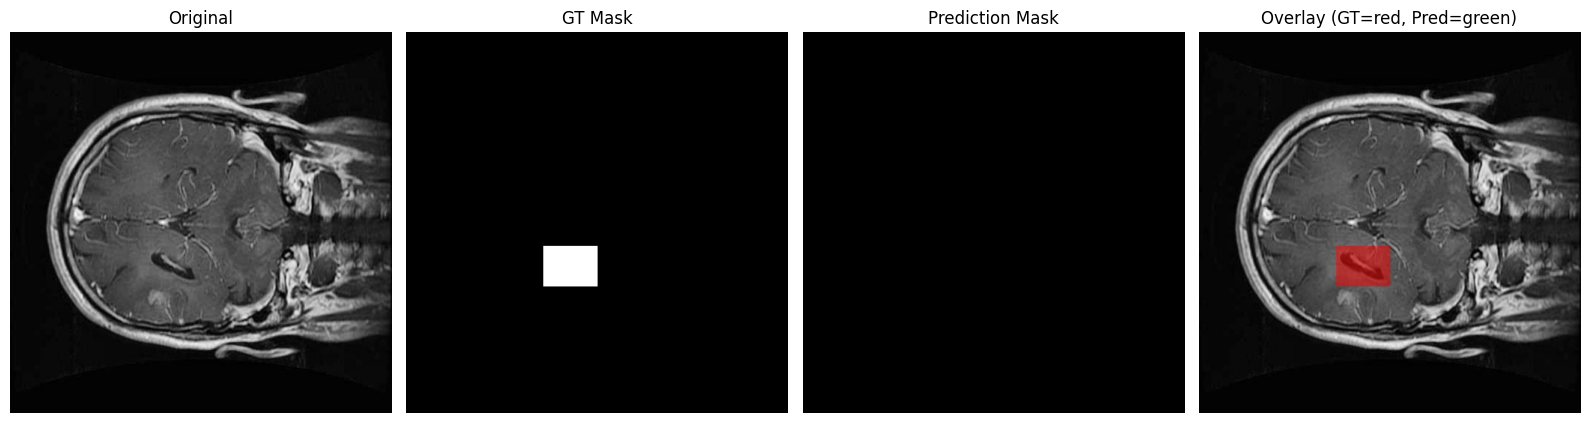


0: 640x640 2 tumors, 51.5ms
Speed: 0.7ms preprocess, 51.5ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 640)


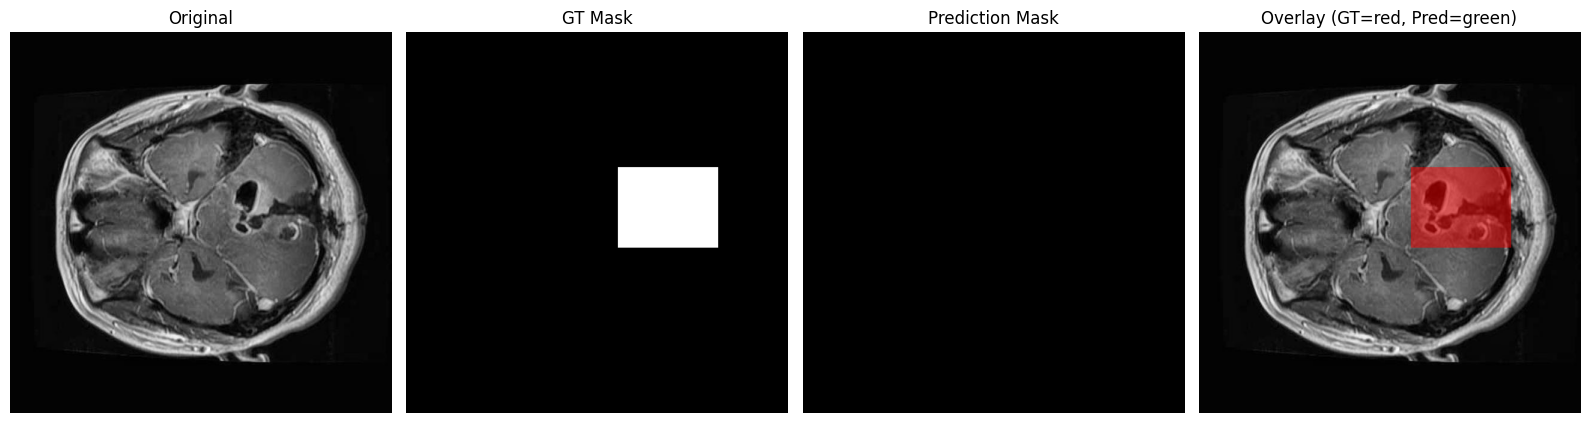


0: 640x640 2 tumors, 50.4ms
Speed: 0.7ms preprocess, 50.4ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 640)


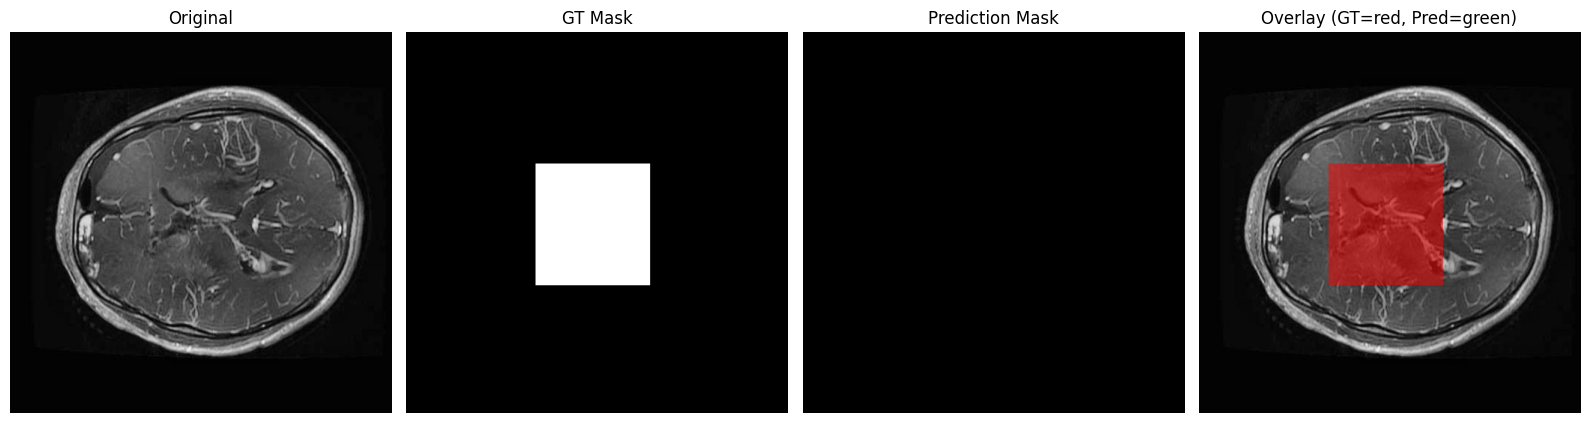

In [ ]:
# %%
from ultralytics import YOLO

model = YOLO("../experiments/yolo_seg_run1/weights/best.pt")
metrics = model.val(
    split="val",
    data="../dataset/dataset.yaml",
)

print("Mask IoU:", metrics.mask.iou)
print("Mask mAP50:", metrics.mask.map50)
print("Mask mAP50-95:", metrics.mask.map)

Automated Per-Image IoU (SEGMENTATION)

Evaluate model (mIoU + mAP)

In [ ]:
# %%
def seg_iou(pred_mask, gt_mask):
    inter = np.logical_and(pred_mask==1, gt_mask==1).sum()
    union = np.logical_or(pred_mask==1, gt_mask==1).sum()
    return inter/union if union>0 else 0

ious = []

for img_id in id2img.keys():
    info = id2img[img_id]
    fname = info["file_name"]
    img_path = f"../dataset/valid/images/{fname}"

    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    h,w = img.shape[:2]

    # GT
    gt_mask = np.zeros((h,w), np.uint8)
    for ann in ann_by_img.get(img_id, []):
        gt_mask |= poly_to_mask(ann["segmentation"][0], w, h)

    # Pred
    pred = model(img)[0]
    pred_mask = np.zeros((h,w), np.uint8)
    if pred.masks is not None:
        for m in pred.masks.data:
            m = cv2.resize(m.cpu().numpy(), (w,h))
            pred_mask |= (m>0.5).astype(np.uint8)

    ious.append(seg_iou(pred_mask, gt_mask))

print("Mean IoU across VALID:", np.mean(ious))

Generate submission masks for TEST set

In [ ]:
# # %%
# test_dir = "../dataset/test/images"
# out_dir = "../dataset/test/labels"
# os.makedirs(out_dir, exist_ok=True)

# for fname in os.listdir(test_dir):
#     if not fname.lower().endswith((".jpg",".png",".jpeg")):
#         continue

#     img = cv2.imread(os.path.join(test_dir, fname))
#     img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#     h,w = img.shape[:2]

#     pred = model(img)[0]
#     pred_mask = np.zeros((h,w), np.uint8)
#     if pred.masks is not None:
#         for m in pred.masks.data:
#             m = cv2.resize(m.cpu().numpy(), (w,h))
#             pred_mask |= (m>0.5).astype(np.uint8)

#     out = fname.rsplit(".",1)[0] + ".txt"
#     out_path = os.path.join(out_dir, out)

#     with open(out_path, "w") as f:
#         # flatten mask into polygons if needed
#         ys, xs = np.where(pred_mask==1)
#         if len(xs)>0:
#             poly = np.stack([xs/w, ys/h], axis=1).reshape(-1)
#             f.write("0 " + " ".join([f"{p:.6f}" for p in poly]) + "\n")

# print("TEST predictions saved → dataset/test/labels/")